## Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 2390

## Read data set

In [2]:
path = 'file/'
#path = '../input/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (95851, 8)
Number of rows and columns in the test data set: (226998, 2)


In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [4]:
test.head()

,id,comment_text
0,6044863,==Orphaned non-free media (Image:41cD1jboEvL. ...
1,6102620,::Kentuckiana is colloquial. Even though the ...
2,14563293,"Hello fellow Wikipedians,\nI have just modifie..."
3,21086297,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
4,22982444,== [WIKI_LINK: Talk:Celts] ==


## Target varaible distribution

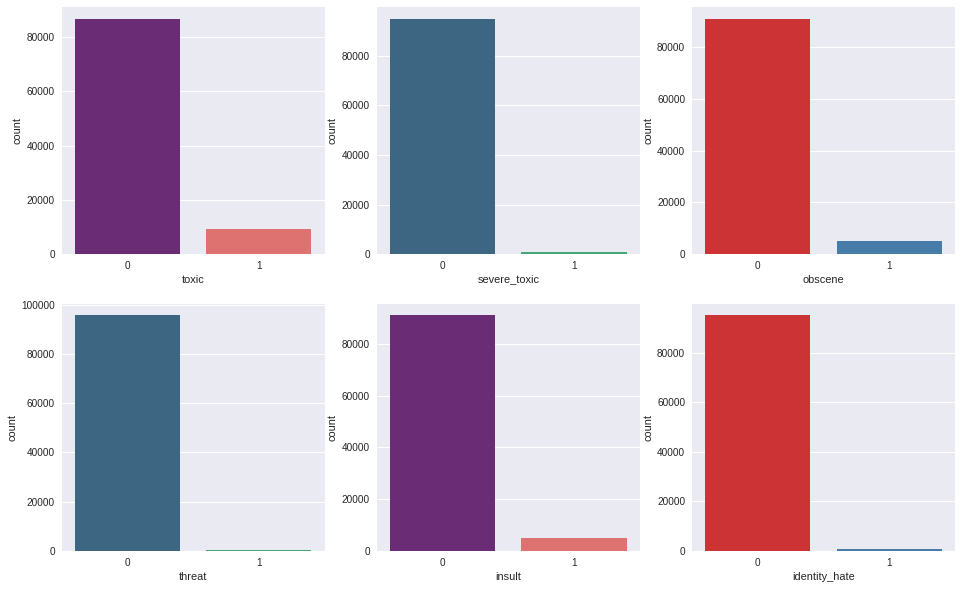

In [25]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

## Missing value

In [5]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['tes'] = test.isnull().sum()
k

,train,tes
id,0,0.0
comment_text,0,1.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [6]:
test[test['comment_text'].isnull()]

,id,comment_text
52300,231298963278,NaN


In [7]:
test.fillna(' ',inplace=True)
gc.collect()

79

## Text preprosesing

In [8]:
vect_word = TfidfVectorizer(max_features=50000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,1),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)

In [9]:
# Word
tr_vect = vect_word.fit_transform(train['comment_text'])
ts_vect = vect_word.transform(test['comment_text'])

# char
tr_vect_char = vect_char.fit_transform(train['comment_text'])
ts_vect_char = vect_char.transform(test['comment_text'])
gc.collect()

X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])


In [ ]:
svd = TruncatedSVD(n_components= 2000,random_state=seed)
train_svd = svd.fit_transform(X)
test_svd = svd.transform(x_test)

In [8]:
X = train_svd
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]
x_test = test_svd
del train_tf,test_tf,train_svd,test_svd
gc.collect()

0

## Model

In [9]:
lr = LogisticRegression(C=4,random_state = seed)
prd = np.zeros((len(x_test),y.shape[1]))
cv_score =[]
for i,col in enumerate( y.columns):
    print('Building model for column:',col) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(x_test)[:,1]

Building model for column: toxic
Building model for column: severe_toxic
Building model for column: obscene
Building model for column: threat
Building model for column: insult
Building model for column: identity_hate


## Model Validation on train data set

In [10]:
print("Column:",col)
pred =  lr.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
print(classification_report(y[col],pred))

Column: identity_hate

Confusion matrix
 [[94971    66]
 [  750    64]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     95037
          1       0.49      0.08      0.14       814

avg / total       0.99      0.99      0.99     95851



## Roc AUC curve

Column: identity_hate


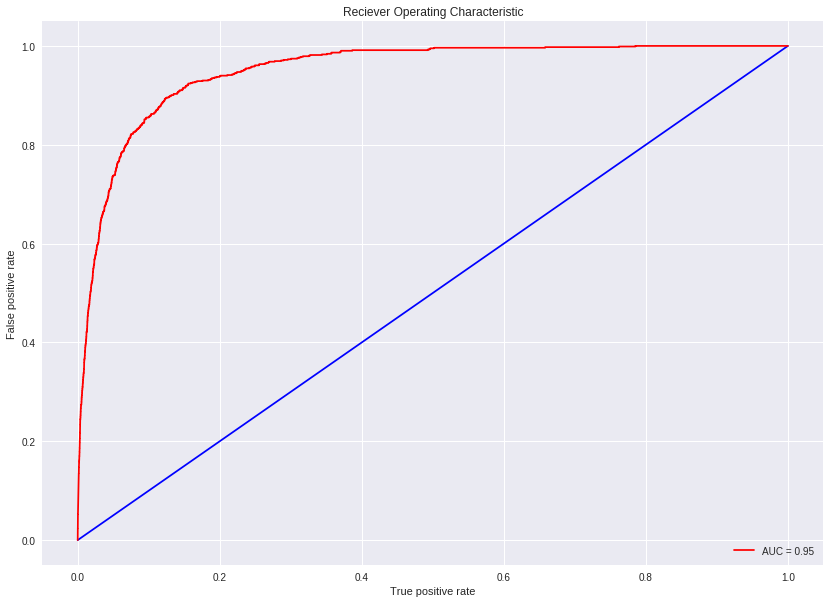

In [12]:
print("Column:",col)
pred_pro = lr.predict_proba(X)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

## submission

In [13]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([test['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
submit.to_csv('toxic_lr.csv',index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.000001,0.000130,0.000006,0.000089,0.000126,0.000588
1,6102620,0.092882,0.007418,0.042256,0.003443,0.053224,0.010457
2,14563293,0.019190,0.002192,0.014887,0.000533,0.004221,0.001007
3,21086297,0.108637,0.010401,0.038764,0.003677,0.050416,0.011490
4,22982444,0.010379,0.001246,0.005251,0.000845,0.006744,0.001460


### Thank you